In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BlipProcessor, BlipModel, BlipForConditionalGeneration
from PIL import Image
import matplotlib.pyplot as plt
import os

# -------------------------
# 0) Device
# -------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

# -------------------------
# 1) Load BLIP
# -------------------------
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")

# Encoder (feature extractor)
blip_encoder = BlipModel.from_pretrained("Salesforce/blip-image-captioning-base").to(device)
blip_encoder.eval()

# Captioning model
blip_captioner = BlipForConditionalGeneration.from_pretrained(
    "Salesforce/blip-image-captioning-base"
).to(device)
blip_captioner.eval()

# -------------------------
# 2) Determine feature dimension
# -------------------------
with torch.no_grad():
    dummy = processor(images=Image.new("RGB", (224, 224)), return_tensors="pt").to(device)
    FEATURE_DIM = blip_encoder.get_image_features(**dummy).shape[-1]
print("BLIP feature dim:", FEATURE_DIM)

# -------------------------
# 3) Dataset
# -------------------------
class ImageFolderDataset(Dataset):
    def __init__(self, root_dir, processor, device):
        self.root_dir = root_dir
        self.processor = processor
        self.device = device
        self.samples = []

        # Collect image paths and labels
        labels_set = set()
        for label_name in sorted(os.listdir(root_dir)):
            label_path = os.path.join(root_dir, label_name)
            if not os.path.isdir(label_path):
                continue
            for fname in os.listdir(label_path):
                if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                    self.samples.append((os.path.join(label_path, fname), label_name))
                    labels_set.add(label_name)

        self.class_names = sorted(list(labels_set))
        self.class_to_idx = {name: idx for idx, name in enumerate(self.class_names)}

    def __len__(self):
        return len(self.samples)


    def __getitem__(self, idx):
        img_path, label_str = self.samples[idx]
        label = torch.tensor(self.class_to_idx[label_str])

        # Extract BLIP feature
        image = Image.open(img_path).convert("RGB")
        inputs = self.processor(images=image, return_tensors="pt").to(self.device)
        with torch.no_grad():
            features = blip_encoder.get_image_features(**inputs)

        return features.squeeze(0), label, img_path

# -------------------------
# 4) Load dataset
# -------------------------
from google.colab import drive
drive.mount('/content/drive')

DATA_DIR = "/content/drive/MyDrive/ALL"  # <-- replace with your folder
dataset = ImageFolderDataset(DATA_DIR, processor, device)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
print("Total images:", len(dataset))

# -------------------------
# 5) Linear classifier and Hessian Flatness
# -------------------------
num_classes = 2
classifier = nn.Linear(FEATURE_DIM, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=1e-3)

# --- (NEW) Hessian Flatness ---
def hessian_vector_product(model, loss, vector):
    grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)
    grad_vector_product = 0
    offset = 0

    # concatenate gradients into one vector
    g = torch.cat([g.contiguous().view(-1) for g in grads])

    # compute dot(g, vector)
    grad_v = torch.dot(g, vector)

    # take gradient of that dot product
    Hv = torch.autograd.grad(grad_v, model.parameters(), retain_graph=True)

    # concatenate again
    Hv = torch.cat([h.contiguous().view(-1) for h in Hv])
    return Hv

def estimate_largest_hessian_eigenvalue(model, features, labels, criterion, iters=20):
    model.eval()
    outputs = model(features)
    loss = criterion(outputs, labels)

    # flatten all model parameters into one vector
    params = [p for p in model.parameters() if p.requires_grad]
    num_params = sum(p.numel() for p in params)

    # random initial vector
    v = torch.randn(num_params, device=features.device)
    v = v / v.norm()

    for _ in range(iters):
        Hv = hessian_vector_product(model, loss, v)
        v = Hv / (Hv.norm() + 1e-6)

    # Rayleigh quotient gives eigenvalue estimate
    lambda_max = torch.dot(v, hessian_vector_product(model, loss, v)).item()
    return lambda_max
    # (NEW)

# -------------------------
# 6) Training loop
# -------------------------
from torch.utils.data import random_split

# Split dataset into train / val
train_size = int(0.85 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

epochs = 20
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []
sharpness_history = []

for epoch in range(epochs):
    # --- Training ---
    classifier.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for features, labels, _ in train_loader:
        features = features.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = classifier(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    # --- Validation ---
    classifier.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for features, labels, _ in val_loader:
            features = features.to(device)
            labels = labels.to(device)
            outputs = classifier(features)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    # get one batch (you can randomize this)
    for features, labels, _ in dataloader: # FIX: Changed from 'for features, labels in dataloader:'
        features, labels = features.to(device), labels.to(device)
        break  # take only one batch for stability

    lambda_max = estimate_largest_hessian_eigenvalue(
        classifier, features, labels, criterion
    )
    #inside epoch loop:
    sharpness_history.append(lambda_max)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}% | "
          f"Hessian Flatness: {lambda_max:.2f}%")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

`BlipModel` is going to be deprecated in future release, please use `BlipForConditionalGeneration`, `BlipForQuestionAnswering` or `BlipForImageTextRetrieval` depending on your usecase.


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-image-captioning-base and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.0.attention.output.LayerNorm.bias', 'text_model.encoder.layer.0.attention.output.LayerNorm.weight', 'text_model.encoder.layer.0.attention.output.dense.bias', 'text_model.encoder.layer.0.attention.output.dense.weight', 'text_model.encoder.layer.0.attention.self.key.bias', 'text_model.encoder.layer.0.attention.self.key.weight', 'text_model.encoder.layer.0.attention.self.query.bias', 'text_model.encoder.layer.0.attention.self.query.weight', 'text_model.encoder.layer.0.attention.self.value.bias', 'text_model.encoder.layer.0.attention.self.value.weight', 'text_model.encoder.layer.0.crossattention.output.LayerNorm.bias', 'text_model.

BLIP feature dim: 512
Mounted at /content/drive
Total images: 200
Epoch 1/20 | Train Loss: 0.5379, Train Acc: 87.06% | Val Loss: 0.4005, Val Acc: 93.33% | Hessian Flatness: 13.74%
Epoch 2/20 | Train Loss: 0.2935, Train Acc: 100.00% | Val Loss: 0.2407, Val Acc: 100.00% | Hessian Flatness: 10.13%
Epoch 3/20 | Train Loss: 0.1695, Train Acc: 100.00% | Val Loss: 0.1520, Val Acc: 100.00% | Hessian Flatness: 8.27%
Epoch 4/20 | Train Loss: 0.1125, Train Acc: 100.00% | Val Loss: 0.1099, Val Acc: 100.00% | Hessian Flatness: 5.38%
Epoch 5/20 | Train Loss: 0.0818, Train Acc: 100.00% | Val Loss: 0.0870, Val Acc: 100.00% | Hessian Flatness: 4.32%
Epoch 6/20 | Train Loss: 0.0628, Train Acc: 100.00% | Val Loss: 0.0711, Val Acc: 100.00% | Hessian Flatness: 3.86%
Epoch 7/20 | Train Loss: 0.0515, Train Acc: 100.00% | Val Loss: 0.0606, Val Acc: 100.00% | Hessian Flatness: 2.65%
Epoch 8/20 | Train Loss: 0.0431, Train Acc: 100.00% | Val Loss: 0.0526, Val Acc: 100.00% | Hessian Flatness: 3.10%
Epoch 9/20 | T

Final Training Loss: 0.0135
Final Training Accuracy: 100.00%
Final Validation Loss: 0.0192
Final Validation Accuracy: 100.00%


<>:34: SyntaxWarning: invalid escape sequence '\l'
<>:34: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-2325879003.py:34: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel("Sharpness ($\lambda_{max}$)")


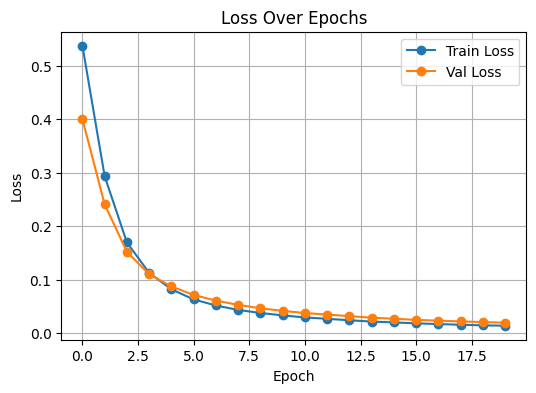

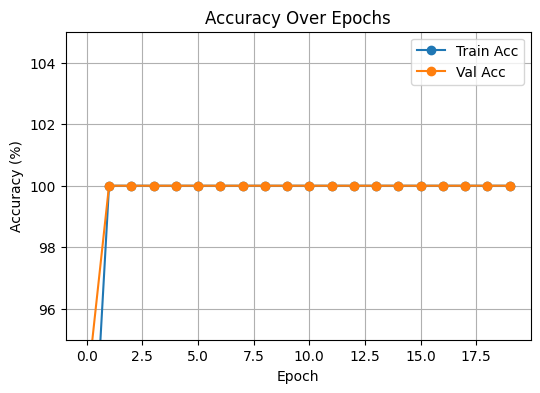

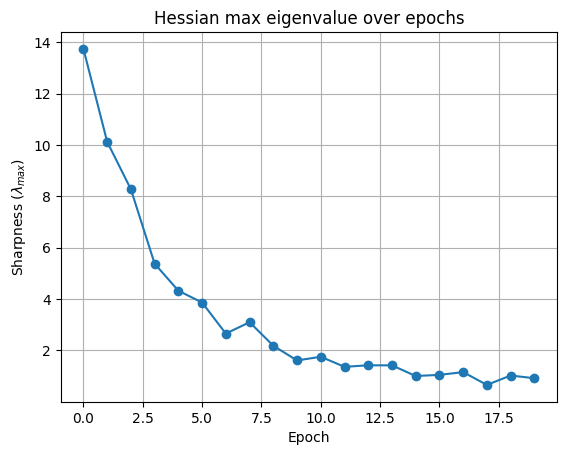

In [ ]:
# Final metrics
print("="*50)
print(f"Final Training Loss: {train_loss_history[-1]:.4f}")
print(f"Final Training Accuracy: {train_acc_history[-1]:.2f}%")
print(f"Final Validation Loss: {val_loss_history[-1]:.4f}")
print(f"Final Validation Accuracy: {val_acc_history[-1]:.2f}%")

# Plot curves
plt.figure(figsize=(6,4))
plt.plot(train_loss_history, marker='o', label='Train Loss')
plt.plot(val_loss_history, marker='o', label='Val Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(train_acc_history, marker='o', label='Train Acc')
plt.plot(val_acc_history, marker='o', label='Val Acc')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.ylim(95,105)
plt.grid(True)
plt.legend()
plt.show()

# Hessian Flatness (NEW)
plt.plot(sharpness_history, marker='o')
plt.title("Hessian max eigenvalue over epochs")
plt.xlabel("Epoch")
plt.ylabel("Sharpness ($\lambda_{max}$)")
plt.grid(True)
plt.show()



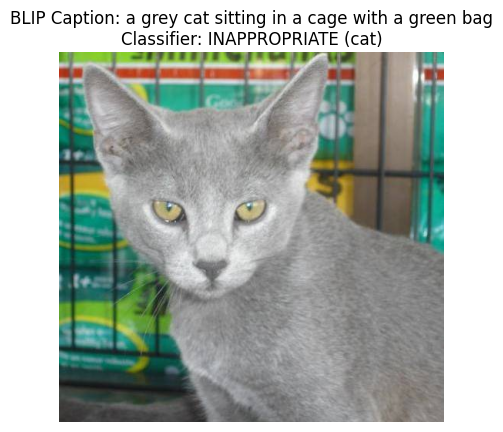

Image: /content/drive/MyDrive/ALL/cat/Copy of cat_001.jpg
Caption: a grey cat sitting in a cage with a green bag
Classifier Output: INAPPROPRIATE (cat)
--------------------------------------------------


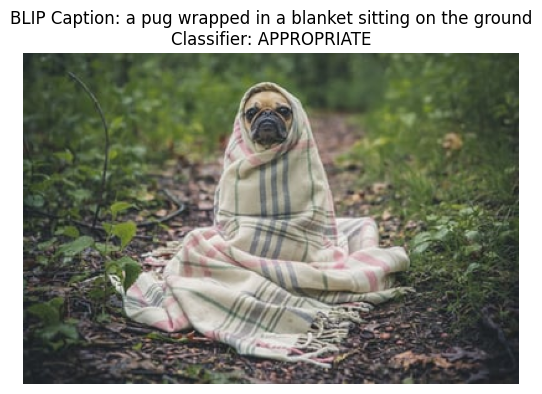

Image: /content/drive/MyDrive/ALL/noncat/photo-1433162653888-a571db5ccccf.jpg
Caption: a pug wrapped in a blanket sitting on the ground
Classifier Output: APPROPRIATE
--------------------------------------------------


In [ ]:
# -------------------------
# 7) Test / inference for multiple images
# -------------------------

def caption_image(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        out = blip_captioner.generate(**inputs)
    caption = processor.decode(out[0], skip_special_tokens=True)
    return caption

def classify_image(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        features = blip_encoder.get_image_features(**inputs)
        outputs = classifier(features)
        _, predicted = torch.max(outputs, 1)
    return predicted.item()

test_images = [
    "/content/drive/MyDrive/ALL/cat/Copy of cat_001.jpg",          # should be INAPPROPRIATE
    "/content/drive/MyDrive/ALL/noncat/photo-1433162653888-a571db5ccccf.jpg"    # should be APPROPRIATE
]

def pretty_predict(image_path):
    caption = caption_image(image_path)
    pred = classify_image(image_path)
    label = "INAPPROPRIATE (cat)" if pred == 0 else "APPROPRIATE"

    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"BLIP Caption: {caption}\nClassifier: {label}")
    plt.show()

    print("Image:", image_path)
    print("Caption:", caption)
    print("Classifier Output:", label)
    print("-" * 50)

# Run prediction on both images
for img_path in test_images:
    pretty_predict(img_path)
